Shapes: (40, 8) (40,)
y range: 5.5921933895401965 → 9.598482002566342
Week 1 added → x: [0.351365 0.099784 0.076173 0.161989 0.36082  0.91595  0.718151 0.668977]  y: 9.0553832140311
Week 2 added → x: [0.088343 0.02128  0.151776 0.018496 0.823879 0.721907 0.134064 0.2023  ]  y: 9.890404044596501
Updated shapes: X=(42, 8), y=(42,)
y range: 5.5922 → 9.8904, mean=7.8942, std=0.9934


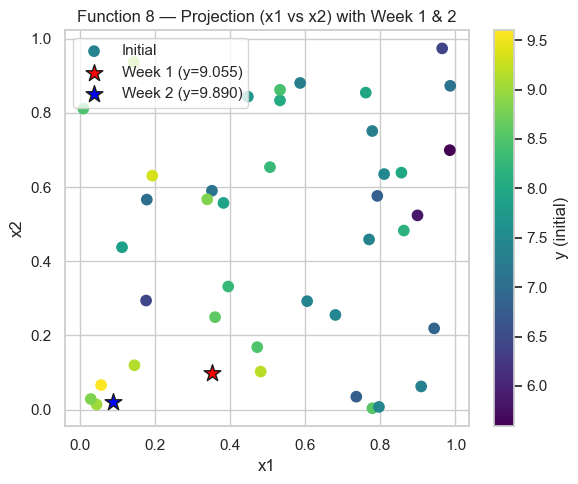

Scaled shapes: (42, 8) (42,)


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_8"

# Cargar arrays
X = np.load(DATA_DIR / "initial_inputs.npy")   # (40, 8)
y = np.load(DATA_DIR / "initial_outputs.npy")  # (40, )

print("Shapes:", X.shape, y.shape)
print("y range:", y.min(), "→", y.max())
# === Semana 1 ===
w1_input  =np.array([0.351365,0.099784, 0.076173,0.161989,0.36082,0.91595,0.718151,0.668977], dtype=float)
w1_output = float(9.0553832140311)

# === Semana 2 ===
w2_input  =np.array([0.088343, 0.02128 , 0.151776, 0.018496, 0.823879, 0.721907,
       0.134064, 0.2023], dtype=float)
w2_output = float(9.890404044596501)

X_prev, y_prev = X.copy(), y.copy()

def append_if_new(X, y, x_new, y_new, tol=1e-9):  
    x_new = np.asarray(x_new, float).ravel()
    assert x_new.shape[0] == X.shape[1], f"Dim mismatch: got {x_new.shape[0]}, expected {X.shape[1]}"
    if np.any(np.all(np.isclose(X, x_new, atol=tol), axis=1)):
        print("  → Punto ya presente, omitido:", x_new)
        return X, y
    # chequeo de dominio [0,1]
    if not np.all((x_new >= 0) & (x_new <= 1)):
        print("  [WARN] Fuera de [0,1]:", x_new)
    return np.vstack([X, x_new]), np.append(y, float(y_new))

# --- Añadir Week 1 y Week 2 (sin duplicar si re-ejecutas) ---
X, y = append_if_new(X, y, w1_input, w1_output)
print("Week 1 added → x:", w1_input, " y:", w1_output)

X, y = append_if_new(X, y, w2_input, w2_output)
print("Week 2 added → x:", w2_input, " y:", w2_output)

print(f"Updated shapes: X={X.shape}, y={y.shape}")     # esperado: (42, 8) y (42,)
print(f"y range: {y.min():.4f} → {y.max():.4f}, mean={y.mean():.4f}, std={y.std():.4f}")

# Visual mínimo (proyección x1–x2)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_prev[:,0], X_prev[:,1], c=y_prev, cmap="viridis", s=55, label="Initial")
plt.colorbar(sc, label="y (initial)")
plt.scatter(w1_input[0], w1_input[1], c="red",  s=160, marker="*", edgecolors="k",
            label=f"Week 1 (y={w1_output:.3f})")
plt.scatter(w2_input[0], w2_input[1], c="blue", s=160, marker="*", edgecolors="k",
            label=f"Week 2 (y={w2_output:.3f})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Function 8 — Projection (x1 vs x2) with Week 1 & 2")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

# --- Escalado (para GP posterior) ---
from sklearn.preprocessing import StandardScaler
sx = StandardScaler().fit(X)
sy = StandardScaler().fit(y.reshape(-1, 1))
Xz = sx.transform(X)
yz = sy.transform(y.reshape(-1, 1)).ravel()
print("Scaled shapes:", Xz.shape, yz.shape)

2) GP (Matern ARD + ruido) y candidatos (LHS 70% TR + 30% global)

In [8]:
# === F8 — GP + candidatos (previo a EI) ===
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
import numpy as np

# 0) Escalado para estabilidad (8D)
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# 1) GP robusto (ARD) para alta dimensión
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(8)*0.5, nu=2.5, length_scale_bounds=(0.03, 3.0))
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-4, 0.2))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=18,
    alpha=1e-10,
    random_state=0
)
gp.fit(Xz, y)
print("Fitted kernel (F8):", gp.kernel_)

# 2) Bounds y Trust Region (anclada en el mejor ACTUAL: W2)
lb = np.zeros(8); ub = np.ones(8)
best_idx = np.argmax(y)          # ya incluye W1+W2
anchor = X[best_idx]
print("Best y:", y[best_idx], "at x:", anchor)

L = 0.30                          # TR más compacta para refinar tras mejora
lb_tr = np.clip(anchor - 0.5*L*(ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5*L*(ub - lb), 0, 1)
print("TR box:", lb_tr, "→", ub_tr)

# 3) Candidatos LHS: 70% TR + 30% global (8D requiere muchos)
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub - lb)

N_tr, N_gl = 90000, 40000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=8030)
C_gl = lhs(lb,    ub,    N_gl, seed=8031)
Cands = np.vstack([C_tr, C_gl]).astype(np.float32)

# 4) Predicción GP en los candidatos (usar el escalador)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

print("Cands:", Cands.shape)

Fitted kernel (F8): 0.769**2 * Matern(length_scale=[2.39, 3, 1.82, 3, 3, 3, 3, 3], nu=2.5) + WhiteKernel(noise_level=0.0001)
Best y: 9.890404044596501 at x: [0.088343 0.02128  0.151776 0.018496 0.823879 0.721907 0.134064 0.2023  ]
TR box: [0.       0.       0.001776 0.       0.673879 0.571907 0.       0.0523  ] → [0.238343 0.17128  0.301776 0.168496 0.973879 0.871907 0.284064 0.3523  ]
Cands: (130000, 8)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py

3) EI (ξ=0.03), anti-borde/duplicado, sugerencia y submission

In [9]:
# === F8 — Adquisición y selección (EI con fallbacks) ===
from scipy.stats import norm
import numpy as np

# --- Predicción (usar el escalador sx sobre Cands) ---
# mu, sigma = gp.predict(Cands, return_std=True)            # (semana anterior)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True) # (ajuste: coherente con el fit)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement ---
# y_best = (y if w1_input is not None else y_prev).max()    # (semana anterior)
y_best = y.max()                                             # (ajuste: ya añadiste W1+W2)
# xi = 0.03                                                  # (semana anterior, más exploración)
xi = 0.02                                                    # (ajuste: explotación moderada tras mejora en W2)

imp = mu - y_best - xi
Z = np.divide(imp, sigma, out=np.zeros_like(imp), where=sigma > 1e-12)
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-borde ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Anti-duplicado (L_inf) ---
def too_close_Linf(c, X, tol=0.02):  # (en 8D mantenemos 0.02 para permitir refinamiento fino)
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Selección con fallbacks: EI → UCB → MaxVar ---
chosen = "None"
order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand; chosen = "EI"
        break

if (x_next is None) or (np.max(ei_masked) <= 0):
    # Fallback 1: Upper Confidence Bound
    # kappa = 1.4                                        # (semana anterior sugerida)
    kappa = 1.4                                          # (mantenemos)
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand; chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Máxima incertidumbre (exploración pura)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand; chosen = "MaxVar"
            break

print(f"Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

Chosen by EI: [0.10575565 0.11672398 0.2111165  0.16270234 0.6908849  0.5748633
 0.2064882  0.35141125]
Submission format:
0.105756 - 0.116724 - 0.211116 - 0.162702 - 0.690885 - 0.574863 - 0.206488 - 0.351411


In [4]:
def within_unit(c): return np.all((c >= 0) & (c <= 1))
print("Within [0,1]? ", within_unit(x_next))
print("Too close? ", too_close_Linf(x_next, X, tol=0.02))

Within [0,1]?  True
Too close?  False


Mini bitácora (F8, W3):
	•	Context: W2 mejoró (9.055 → 9.890), indicio de meseta prometedora.
	•	Model: GP (Matern ν=2.5, ARD) con StandardScaler en X; ruido bajo.
	•	Acq: EI con ξ=0.02, TR 70% anclada en W2 + 30% global; anti-borde y anti-duplicado.
	•	Submission: arriba.
	•	Siguiente: si sube de nuevo, reducir ξ→0.015 y estrechar TR (L≈0.25). Si no mejora, subir ξ→0.03 y abrir TR (L≈0.35).
